**Level 3**
**Task 8: Traffic Sign Recognition Description**

Description:


*   Dataset (Recommended): GTSRB (Kaggle).
*   Classify traffic signs based on their image using deep learning.
*   Preprocess images (resizing, normalization).
*   Train a CNN model to recognize different traffic sign classes.
*   Evaluate performance using accuracy and confusion matrix.







Tools & Libraries:


*   Python
*   Keras
*   TensorFlow
*   OpenCV


Covered Topics:


*   Computer vision (CNN)
*   Multi-class classification






Bonus:


*   Add data augmentation to improve performance.
*   Compare custom CNN vs. pre-trained model (e.g., MobileNet).



In [ ]:
import re
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===== Preprocessing + CNN =====

# -------------------------
# Config
# -------------------------
TRAIN_DIR  = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"
IMG_SIZE   = 48
BATCH_SIZE = 64
VAL_SPLIT  = 0.2
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE

# If there are PPM images, keep this True to use OpenCV (PPM-friendly).
USE_OPENCV = True

# -------------------------
# 1) Recursively list files (supports multiple depths)
# -------------------------
exts = ["png", "ppm", "jpg", "jpeg", "PNG", "PPM", "JPG", "JPEG"]

def recursive_glob(root):
    # Gather a few depth patterns explicitly (tf.io.gfile.glob has no **)
    patterns = []
    for ext in exts:
        patterns += [
            f"{root}/*/*.{ext}",
            f"{root}/*/*/*.{ext}",
            f"{root}/*/*/*/*.{ext}",
            f"{root}/*/*/*/*/*.{ext}",
        ]
    files = []
    for pat in patterns:
        files.extend(tf.io.gfile.glob(pat))
    return sorted(set(files))

file_list = recursive_glob(TRAIN_DIR)
print("Total files found (all depths):", len(file_list))
if len(file_list) == 0:
    raise ValueError(
        f"No images found under {TRAIN_DIR}. "
        "Check the path/mount and that the dataset is extracted."
    )

# -------------------------
# 2) Extract label from the LAST numeric folder in the path
# -------------------------
def extract_numeric_label_from_path(path: str):
    parts = path.replace("\\", "/").split("/")
    for seg in reversed(parts[:-1]):  # skip filename
        if re.fullmatch(r"[0-9]+", seg):
            return int(seg)
    return None

paths, labels = [], []
skipped_non_numeric = 0
for p in file_list:
    lab = extract_numeric_label_from_path(p)
    if lab is None:
        skipped_non_numeric += 1
        continue
    paths.append(p)
    labels.append(lab)

print(f"Kept {len(paths)} files with numeric labels; skipped non-numeric parents: {skipped_non_numeric}")
if len(paths) == 0:
    raise ValueError(
        "After scanning, no files had a numeric folder anywhere in their path. "
        "You should have .../<digits>/file.ext somewhere."
    )

# Compact labels to 0..C-1
unique_labels = sorted(set(labels))
label_to_id = {lab: i for i, lab in enumerate(unique_labels)}
labels_compact = [label_to_id[l] for l in labels]
num_classes = len(unique_labels)
print(f"Detected {num_classes} classes.")

# -------------------------
# 3) Deterministic 80/20 split (no sklearn)
# -------------------------
rng = tf.random.Generator.from_seed(SEED)
perm = rng.uniform(shape=(len(paths),), minval=0, maxval=1, dtype=tf.float32).numpy().argsort()

paths = [paths[i] for i in perm]
labels_compact = [labels_compact[i] for i in perm]

n = len(paths)
n_val = max(1, int(n * VAL_SPLIT))
val_paths  = paths[:n_val]
val_labels = labels_compact[:n_val]
train_paths  = paths[n_val:]
train_labels = labels_compact[n_val:]

print(f"Train files: {len(train_paths)} | Val files: {len(val_paths)}")
if len(train_paths) == 0:
    raise ValueError("Empty training set after split — reduce VAL_SPLIT or check dataset.")

# -------------------------
# 4) Preprocessing (TF or OpenCV)
# -------------------------
def decode_resize_normalize_tf(path: tf.Tensor, label: tf.Tensor):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)  # (H,W,3) uint8
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img, label

# >>> FIXED: use .numpy().decode('utf-8') inside py_function
def _decode_resize_normalize_cv2_py(path_tensor):
    path = path_tensor.numpy().decode("utf-8")
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)  # BGR, uint8
    if bgr is None:
        return (tf.zeros((IMG_SIZE, IMG_SIZE, 3), tf.float32)).numpy()
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = rgb.astype("float32") / 255.0
    return rgb

def decode_resize_normalize_cv2(path: tf.Tensor, label: tf.Tensor):
    img = tf.py_function(_decode_resize_normalize_cv2_py, [path], Tout=tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))  # static shape for batching
    return img, label

preproc = decode_resize_normalize_cv2 if USE_OPENCV else decode_resize_normalize_tf

# -------------------------
# 5) Build tf.data pipelines
# -------------------------
train_ds = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
            .shuffle(buffer_size=len(train_paths), seed=SEED, reshuffle_each_iteration=True)
            .map(preproc, num_parallel_calls=AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
          .map(preproc, num_parallel_calls=AUTOTUNE))

# Optional augmentation (avoid horizontal flip for traffic signs)
augment = keras.Sequential([
    layers.RandomTranslation(0.06, 0.06, fill_mode="nearest"),
    layers.RandomContrast(0.1),
    layers.RandomZoom(0.1),
], name="augment")

def augment_if_needed(img, label):
    img = augment(img, training=True)
    return img, label

train_ds = train_ds.map(augment_if_needed, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# -------------------------
# 6) Small CNN model
# -------------------------
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds, validation_data=val_ds, epochs=15)

# -------------------------
# 7) Evaluation
# -------------------------
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")


Total files found (all depths): 19650
Kept 6957 files with numeric labels; skipped non-numeric parents: 12693
Detected 7 classes.
Train files: 5566 | Val files: 1391
Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 902s 10s/step - accuracy: 0.3013 - loss: 1.6671 - val_accuracy: 0.6643 - val_loss: 0.8671
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.6858 - loss: 0.8038 - val_accuracy: 0.9482 - val_loss: 0.2177
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.9004 - loss: 0.3059 - val_accuracy: 0.9741 - val_loss: 0.1170
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - accuracy: 0.9524 - loss: 0.1617 - val_accuracy: 0.9885 - val_loss: 0.0581
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.9685 - loss: 0.1087 - val_accuracy: 0.9914 - val_loss: 0.0432
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.9774 - loss: 0.0785 - val_accuracy: 0.9928 - val_loss: 0.0304
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 299ms/step - accura

In [ ]:
# ================================
# Train a CNN
# ================================

# -------------------------
# Config
# -------------------------
TRAIN_DIR  = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"
IMG_SIZE   = 48
BATCH_SIZE = 64
VAL_SPLIT  = 0.2
EPOCHS     = 20
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE
USE_OPENCV = False  # True = OpenCV decode (ppm-friendly), False = pure TF

# -------------------------
# Robust file listing (no assertions if a pattern has no matches)
# -------------------------
exts = ["png", "jpg", "jpeg", "ppm", "PNG", "JPG", "JPEG", "PPM"]
paths = []
for ext in exts:
    # two-level deep; add more /*/*/* if your data is deeper
    paths += tf.io.gfile.glob(f"{TRAIN_DIR}/*/*.{ext}")
    paths += tf.io.gfile.glob(f"{TRAIN_DIR}/*/*/*.{ext}")

# Deduplicate & sort for deterministic split
paths = sorted(set(paths))
if not paths:
    raise ValueError(f"No image files found under {TRAIN_DIR}. "
                     "Check the path and depth; add more /* if needed.")

# -------------------------
# Label extraction: take the LAST numeric folder as class id
# -------------------------
def extract_label_from_path(p: str) -> int:
    parts = p.replace("\\", "/").split("/")
    # scan from the end (skip filename at [-1])
    for seg in reversed(parts[:-1]):
        if re.fullmatch(r"[0-9]+", seg):
            return int(seg)
    # if none found, return -1 to drop later
    return -1

labels = [extract_label_from_path(p) for p in paths]
keep = [i for i, lab in enumerate(labels) if lab >= 0]
paths = [paths[i] for i in keep]
labels = [labels[i] for i in keep]

if not paths:
    raise ValueError("All files were filtered out because no numeric class folder was found "
                     "(expected .../<digits>/filename.ext). Check your layout.")

# Remap labels to 0..C-1 (compact)
unique_labs = sorted(set(labels))
lab2id = {lab: i for i, lab in enumerate(unique_labs)}
labels = [lab2id[lab] for lab in labels]
num_classes = len(unique_labs)
print(f"Found {len(paths)} images across {num_classes} classes.")

# -------------------------
# Build datasets (deterministic split)
# -------------------------
ds_all = tf.data.Dataset.from_tensor_slices((paths, labels))
ds_all = ds_all.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=False)

n_total = len(paths)
n_val = max(1, int(n_total * VAL_SPLIT))
val_files = ds_all.take(n_val)
trn_files = ds_all.skip(n_val)

# Label tensor is second element from ds_all; we’ll map after preprocessing
def path_to_label_from_pair(path, label):
    return path, tf.cast(label, tf.int32)

val_files = val_files.map(path_to_label_from_pair)
trn_files = trn_files.map(path_to_label_from_pair)

# -------------------------
# Preprocessing
# -------------------------
def decode_resize_normalize_tf(path: tf.Tensor, label: tf.Tensor):
    bytestr = tf.io.read_file(path)
    img = tf.io.decode_image(bytestr, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

def _preprocess_cv2_py(path_tensor):
    path = path_tensor.numpy().decode("utf-8")
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        return (tf.zeros((IMG_SIZE, IMG_SIZE, 3), tf.float32)).numpy()
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = (rgb.astype("float32") / 255.0)
    return rgb

def decode_resize_normalize_cv2(path: tf.Tensor, label: tf.Tensor):
    img = tf.py_function(_preprocess_cv2_py, [path], Tout=tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img, label

preprocess = decode_resize_normalize_cv2 if USE_OPENCV else decode_resize_normalize_tf

train_ds = trn_files.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_files.map(preprocess, num_parallel_calls=AUTOTUNE)

# -------------------------
# Augmentation (mild for traffic signs)
# -------------------------
augment = keras.Sequential([
    layers.RandomTranslation(0.05, 0.05, fill_mode="nearest"),
    layers.RandomContrast(0.1),
], name="augment")

def aug_fn(img, label):
    return augment(img, training=True), label

train_ds = (train_ds
            .map(aug_fn, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(min(10000, n_total), seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (val_ds
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

# -------------------------
# CNN model
# -------------------------
def build_model(num_classes):
    return keras.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(), layers.Dropout(0.15),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(), layers.Dropout(0.15),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(), layers.Dropout(0.2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ])

model = build_model(num_classes)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

# -------------------------
# Evaluation
# -------------------------
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"\nValidation accuracy: {val_acc:.4f}")

# Confusion matrix + per-class accuracy
y_true, y_pred = [], []
for xb, yb in val_ds:
    logits = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(tf.argmax(logits, axis=1).numpy().tolist())

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
print("\nConfusion matrix:\n", cm.numpy())

diag = tf.linalg.diag_part(cm)
per_class_acc = tf.math.divide_no_nan(tf.cast(diag, tf.float32),
                                      tf.cast(tf.reduce_sum(cm, axis=1), tf.float32))
print("\nPer-class accuracy:")
for cls_id, acc in enumerate(per_class_acc.numpy().tolist()):
    print(f"Class {unique_labs[cls_id]:02d} -> idx {cls_id:02d}: {acc:.3f}")


Found 6957 images across 7 classes.
Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.2437 - loss: 2.1704 - val_accuracy: 0.3602 - val_loss: 1.5172 - learning_rate: 0.0010
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.3653 - loss: 1.4638 - val_accuracy: 0.5464 - val_loss: 0.9747 - learning_rate: 0.0010
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5821 - loss: 0.9686 - val_accuracy: 0.6520 - val_loss: 0.8375 - learning_rate: 0.0010
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7125 - loss: 0.6862 - val_accuracy: 0.8699 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8814 - loss: 0.3063 - val_accuracy: 0.9827 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9562 - loss: 0.1197 - val_accuracy: 0.9777 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accur

Validation Accuracy: 0.9986
Validation Loss: 0.0085

Confusion Matrix (rows = true, cols = predicted):

[[231   0   0   0   0   0   0]
 [  0 372   0   0   0   0   0]
 [  0   0  75   0   0   0   0]
 [  0   1   0 307   0   0   0]
 [  0   0   0   0 287   1   0]
 [  0   0   0   0   0  63   0]
 [  0   0   0   0   0   0  54]]


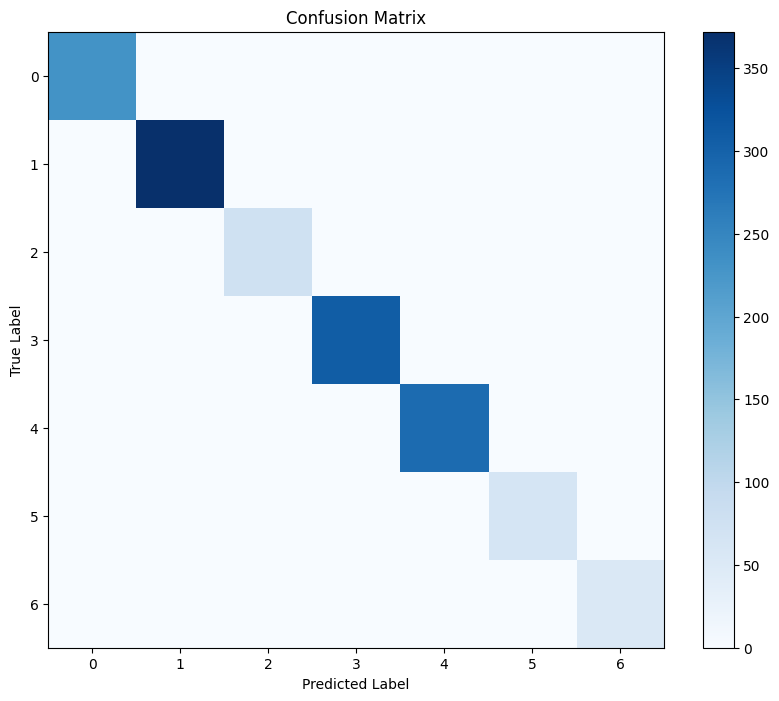


Per-class accuracy:
Class 00: 1.000
Class 01: 1.000
Class 02: 1.000
Class 03: 0.997
Class 04: 0.997
Class 05: 1.000
Class 06: 1.000


In [ ]:
# ---- Evaluate overall accuracy ----
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# ---- Collect predictions and true labels ----
y_true, y_pred = [], []
for xb, yb in val_ds:
    preds = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(tf.argmax(preds, axis=1).numpy().tolist())

# ---- Confusion matrix (TensorFlow-only) ----
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)

print("\nConfusion Matrix (rows = true, cols = predicted):\n")
print(cm.numpy())

# ---- Plot confusion matrix as heatmap ----
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ---- Per-class accuracy ----
diag = tf.linalg.diag_part(cm)
per_class_acc = diag / tf.reduce_sum(cm, axis=1)

print("\nPer-class accuracy:")
for cls, acc in enumerate(per_class_acc.numpy().tolist()):
    print(f"Class {cls:02d}: {acc:.3f}")


In [ ]:
# Keep augmentations mild: signs are orientation-sensitive
augment = keras.Sequential([
    layers.RandomTranslation(height_factor=0.06, width_factor=0.06, fill_mode="nearest"),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode="nearest"),
    layers.RandomRotation(factor=0.05, fill_mode="nearest"),  # ~±9°
    layers.RandomContrast(0.1),
], name="augment")

def aug_fn(img, label):
    img = augment(img, training=True)
    return img, label

# apply to your train dataset (keep val_ds clean!)
train_ds = (train_ds   # <-- use your preprocessed, UNBATCHED train dataset here
            .map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(10_000, seed=42, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

# val_ds should remain: val_ds = val_ds_unbatched.batch(BATCH_SIZE).prefetch(...)


In [ ]:
# Keep augmentations mild: signs are orientation-sensitive
augment = keras.Sequential([
    layers.RandomTranslation(height_factor=0.06, width_factor=0.06, fill_mode="nearest"),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode="nearest"),
    layers.RandomRotation(factor=0.05, fill_mode="nearest"),  # ~±9°
    layers.RandomContrast(0.1),
], name="augment")

def aug_fn(img, label):
    img = augment(img, training=True)
    return img, label

# apply to your train dataset (keep val_ds clean!)
train_ds = (train_ds   # <-- use your preprocessed, UNBATCHED train dataset here
            .map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(10_000, seed=42, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

# val_ds should remain: val_ds = val_ds_unbatched.batch(BATCH_SIZE).prefetch(...)


In [ ]:
num_classes = 43  # GTSRB

def one_hot(y):
    return tf.one_hot(y, depth=num_classes)

def sample_beta(alpha=0.2, shape=()):
    # Beta(alpha, alpha) via Gamma sampling
    gamma1 = tf.random.gamma(shape=shape, alpha=[alpha])
    gamma2 = tf.random.gamma(shape=shape, alpha=[alpha])
    lam = gamma1 / (gamma1 + gamma2)
    return tf.cast(lam[0], tf.float32)

def mixup_batch(images, labels, alpha=0.2):
    lam = sample_beta(alpha, shape=(images.shape[0],))
    lam_img = tf.reshape(lam, (-1, 1, 1, 1))
    lam_lbl = tf.reshape(lam, (-1, 1))

    # Shuffle within the batch
    idx = tf.random.shuffle(tf.range(tf.shape(images)[0]))
    images2 = tf.gather(images, idx)
    labels2 = tf.gather(labels, idx)

    mixed_images = images * lam_img + images2 * (1.0 - lam_img)
    mixed_labels = one_hot(labels) * lam_lbl + one_hot(labels2) * (1.0 - lam_lbl)
    return mixed_images, mixed_labels

def mixup_map(images, labels):
    return tf.py_function(
        func=lambda x, y: mixup_batch(x, y, alpha=0.2),
        inp=[images, labels],
        Tout=[tf.float32, tf.float32]
    )

# Build an augmented + MixUp pipeline
train_ds = (train_ds
            .map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)      # A) geometric/photometric aug
            .shuffle(10_000, seed=42, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE)
            .map(mixup_map, num_parallel_calls=tf.data.AUTOTUNE)   # B) MixUp after batching
            .prefetch(tf.data.AUTOTUNE))

# If you enable MixUp, compile with categorical loss:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",       # <- because labels are mixed one-hots
    metrics=["accuracy"]
)


In [ ]:
# ================================
# GTSRB: Compare Custom CNN vs MobileNetV2
# ================================

# -------------------------
# Config
# -------------------------
TRAIN_DIR  = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"  # adjust as needed
IMG_SIZE   = 64          # 48 or 64 work well
BATCH_SIZE = 64
VAL_SPLIT  = 0.2
EPOCHS_SCRATCH = 18
EPOCHS_TL_WARM = 6       # frozen warm-up for MobileNet
EPOCHS_TL_FT   = 10      # fine-tune epochs
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE
USE_OPENCV = False       # True = decode/resize with OpenCV; False = pure TF

# -------------------------
# List files (TF-only; no os/glob)
# Folder layout: train/<class_id>/*.(png|ppm|jpg|jpeg)
# -------------------------
patterns = [
    f"{TRAIN_DIR}/*/*.png", f"{TRAIN_DIR}/*/*.ppm",
    f"{TRAIN_DIR}/*/*.jpg", f"{TRAIN_DIR}/*/*.jpeg"
]
files = tf.data.Dataset.from_tensor_slices(patterns)
files = files.flat_map(tf.data.Dataset.list_files).shuffle(200_000, seed=SEED, reshuffle_each_iteration=False)

# Label from folder name
def path_to_label(path: tf.Tensor) -> tf.Tensor:
    parts = tf.strings.split(path, "/")
    return tf.strings.to_number(parts[-2], out_type=tf.int32)  # e.g., "00014" -> 14

# A) Pure-TF decode/resize/normalize to [0,1]
def decode_tf(path: tf.Tensor):
    label = path_to_label(path)
    img = tf.io.decode_image(tf.io.read_file(path), channels=3, expand_animations=False)  # uint8
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img, label

# B) OpenCV (optional)
def _decode_cv2_py(path_bytes):
    path = path_bytes.decode("utf-8")
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        return (tf.zeros((IMG_SIZE, IMG_SIZE, 3), tf.float32)).numpy()
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = (rgb.astype("float32") / 255.0)
    return rgb

def decode_cv2(path: tf.Tensor):
    label = path_to_label(path)
    img = tf.py_function(_decode_cv2_py, [path], Tout=tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img, label

decode = decode_cv2 if USE_OPENCV else decode_tf

# Materialize file list to split (cardinality can be unknown)
file_list = list(files.as_numpy_iterator())
N = len(file_list)
n_val = int(N * VAL_SPLIT)
val_files = tf.data.Dataset.from_tensor_slices(file_list[:n_val])
trn_files = tf.data.Dataset.from_tensor_slices(file_list[n_val:])

# Base, unbatched datasets with images in [0,1]
train_base = trn_files.map(decode, num_parallel_calls=AUTOTUNE)
val_base   = val_files.map(decode, num_parallel_calls=AUTOTUNE)

# Augment (kept mild & realistic)
augment = keras.Sequential([
    layers.RandomTranslation(0.06, 0.06, fill_mode="nearest"),
    layers.RandomZoom((-0.1, 0.1), (-0.1, 0.1), fill_mode="nearest"),
    layers.RandomRotation(0.06, fill_mode="nearest"),
    layers.RandomContrast(0.1),
], name="augment")

def augment_fn(img, label):
    return augment(img, training=True), label

# ----- Pipeline for Custom CNN (expects [0,1]) -----
train_custom = (train_base
                .map(augment_fn, num_parallel_calls=AUTOTUNE)
                .cache()
                .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE))
val_custom = (val_base.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE))

# ----- Pipeline for MobileNetV2 (expects preprocess_input) -----
def to_mobilenet(img, label):
    # our img is float32 in [0,1] → scale to [0,255] then preprocess_input (→ [-1,1])
    img = preprocess_input(img * 255.0)
    return img, label

train_mnet = (train_base
              .map(augment_fn, num_parallel_calls=AUTOTUNE)
              .map(to_mobilenet, num_parallel_calls=AUTOTUNE)
              .cache()
              .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
              .batch(BATCH_SIZE)
              .prefetch(AUTOTUNE))
val_mnet = (val_base
            .map(to_mobilenet, num_parallel_calls=AUTOTUNE)
            .cache().batch(BATCH_SIZE).prefetch(AUTOTUNE))

# Infer number of classes
for _, yb in val_custom.take(1):
    num_classes = int(tf.reduce_max(yb).numpy()) + 1

# -------------------------
# Models
# -------------------------
def build_custom_cnn(num_classes: int):
    return keras.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(), layers.Dropout(0.15),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(), layers.Dropout(0.15),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(), layers.Dropout(0.20),

        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.30),
        layers.Dense(num_classes, activation="softmax"),
    ])

def build_mobilenet_v2_head(num_classes: int):
    base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
    base.trainable = False  # warm-up
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model, base

# -------------------------
# Training helpers
# -------------------------
def train_and_eval(model, train_ds, val_ds, epochs, lr=1e-3, tag="Model"):
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    cbs = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, verbose=1)
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"\n[{tag}] Validation accuracy: {val_acc:.4f}")
    return val_acc

def confusion_matrix_tf(model, val_ds, num_classes: int, tag="Model"):
    y_true, y_pred = [], []
    for xb, yb in val_ds:
        logits = model.predict(xb, verbose=0)
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(tf.argmax(logits, axis=1).numpy().tolist())
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
    print(f"\n[{tag}] Confusion matrix (rows=true, cols=pred):\n", cm.numpy())
    diag = tf.linalg.diag_part(cm)
    per_cls = diag / tf.reduce_sum(cm, axis=1)
    print(f"\n[{tag}] Per-class accuracy:")
    for cls, acc in enumerate(per_cls.numpy().tolist()):
        print(f"  class {cls:02d}: {acc:.3f}")
    return cm

# -------------------------
# 1) Train Custom CNN
# -------------------------
custom = build_custom_cnn(num_classes)
acc_custom = train_and_eval(custom, train_custom, val_custom, epochs=EPOCHS_SCRATCH, tag="Custom CNN")
cm_custom = confusion_matrix_tf(custom, val_custom, num_classes, tag="Custom CNN")

# -------------------------
# 2) Train MobileNetV2 (transfer learning)
#    (a) warm-up with backbone frozen, (b) fine-tune upper layers
# -------------------------
mnet, base = build_mobilenet_v2_head(num_classes)
acc_warm = train_and_eval(mnet, train_mnet, val_mnet, epochs=EPOCHS_TL_WARM, lr=1e-3, tag="MobileNetV2 (frozen)")

# Unfreeze last third of layers for fine-tuning
for i, layer in enumerate(base.layers):
    layer.trainable = (i >= int(len(base.layers) * 0.66))
acc_finetuned = train_and_eval(mnet, train_mnet, val_mnet, epochs=EPOCHS_TL_FT, lr=1e-4, tag="MobileNetV2 (fine-tuned)")
cm_mnet = confusion_matrix_tf(mnet, val_mnet, num_classes, tag="MobileNetV2 (fine-tuned)")

# -------------------------
# Summary
# -------------------------
print("\n================ Summary ================")
print(f"Custom CNN accuracy           : {acc_custom:.4f}")
print(f"MobileNetV2 (frozen) accuracy : {acc_warm:.4f}")
print(f"MobileNetV2 (fine-tuned) acc  : {acc_finetuned:.4f}")
print("=========================================")


In [ ]:
# ================================
# GTSRB preprocessing (resize + normalize)
# ================================

# -------------------------
# Config
# -------------------------
TRAIN_DIR = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"
TEST_DIR  = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"
IMG_SIZE  = 48         # 32/48/64 are common for GTSRB; 48 is a good balance
BATCH     = 64
VAL_SPLIT = 0.2
SEED      = 42
AUTOTUNE  = tf.data.AUTOTUNE

# -------------------------
# File listing (TF-only; no os/glob)
# Train assumed as Train/<class_id>/*.ext
# -------------------------
train_patterns = [
    f"{TRAIN_DIR}/*/*.png", f"{TRAIN_DIR}/*/*.ppm",
    f"{TRAIN_DIR}/*/*.jpg", f"{TRAIN_DIR}/*/*.jpeg"
]
train_files = (tf.data.Dataset.from_tensor_slices(train_patterns)
               .flat_map(tf.data.Dataset.list_files)
               .shuffle(200_000, seed=SEED, reshuffle_each_iteration=False))

# Extract integer label from the parent folder name
def path_to_label(path: tf.Tensor) -> tf.Tensor:
    parts = tf.strings.split(path, "/")
    return tf.strings.to_number(parts[-2], out_type=tf.int32)  # e.g., ".../00014/img.ppm" -> 14

# -------------------------
# OpenCV-based decode → resize → normalize to [0,1]
# (kept to your requirement to use cv2)
# -------------------------
def _read_cv2(path_bytes):
    path = path_bytes.decode("utf-8")
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)       # BGR uint8
    if bgr is None:
        # fallback to black image if read fails
        return (tf.zeros((IMG_SIZE, IMG_SIZE, 3), tf.float32)).numpy()
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = rgb.astype("float32") / 255.0            # normalize to [0,1]
    return rgb

def preprocess_with_cv2(path: tf.Tensor):
    label = path_to_label(path)
    img = tf.py_function(_read_cv2, [path], Tout=tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img, label

# -------------------------
# Split into train/val without pandas/sklearn
# -------------------------
# Materialize list to determine size (cardinality can be unknown)
file_list = list(train_files.as_numpy_iterator())
N = len(file_list)
n_val = int(N * VAL_SPLIT)

val_files   = tf.data.Dataset.from_tensor_slices(file_list[:n_val])
train_files = tf.data.Dataset.from_tensor_slices(file_list[n_val:])

train_ds_unbatched = val_files.map(preprocess_with_cv2, num_parallel_calls=AUTOTUNE)
val_ds_unbatched   = train_files.map(preprocess_with_cv2, num_parallel_calls=AUTOTUNE)

# (swap names to keep the conventional split: last part as validation)
train_ds_unbatched, val_ds_unbatched = val_ds_unbatched, train_ds_unbatched

# Optional mild augmentation (good for generalization; keep realistic)
augment = keras.Sequential([
    layers.RandomTranslation(0.06, 0.06, fill_mode="nearest"),
    layers.RandomZoom((-0.1, 0.1), (-0.1, 0.1), fill_mode="nearest"),
    layers.RandomRotation(0.06, fill_mode="nearest"),
    layers.RandomContrast(0.1),
], name="augment")

def aug_fn(img, label):
    return augment(img, training=True), label

# Final datasets
train_ds = (train_ds_unbatched
            .map(aug_fn, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH)
            .prefetch(AUTOTUNE))

val_ds = (val_ds_unbatched
          .cache()
          .batch(BATCH)
          .prefetch(AUTOTUNE))

# -------------------------
# (Optional) Build a tiny CNN to verify the pipeline
# -------------------------
for _, yb in val_ds.take(1):
    num_classes = int(tf.reduce_max(yb).numpy()) + 1  # infer from labels

model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")


In [ ]:
class GTSRBPreprocessor:
    def __init__(self, dataset_path, target_size=(32, 32)):
        """
        Initialize GTSRB preprocessor

        Args:
            dataset_path (str): Path to the GTSRB dataset folder
            target_size (tuple): Target image size (height, width)
        """
        self.dataset_path = dataset_path
        self.target_size = target_size

    def load_csv_file(self, filename):
        """
        Load CSV file manually using TensorFlow file operations

        Args:
            filename (str): Name of the CSV file

        Returns:
            tuple: (data, headers)
        """
        filepath = self.dataset_path + '/' + filename

        try:
            # Read file using TensorFlow
            file_content = tf.io.read_file(filepath)
            lines = tf.strings.split(file_content, '\n')

            # Convert to python list for processing
            lines_list = [line.numpy().decode('utf-8') for line in lines if line.numpy().decode('utf-8').strip()]

            if not lines_list:
                print(f"Error: Empty file {filename}")
                return None, None

            # Get headers from first line
            headers = [h.strip() for h in lines_list[0].split(',')]

            # Process data lines
            data = []
            for line in lines_list[1:]:
                if line.strip():  # Skip empty lines
                    values = [v.strip() for v in line.split(',')]
                    row_dict = {}
                    for i, header in enumerate(headers):
                        if i < len(values):
                            # Try to convert to int if it looks like a number
                            value = values[i]
                            if value.isdigit() or (value.startswith('-') and value[1:].isdigit()):
                                row_dict[header] = int(value)
                            else:
                                row_dict[header] = value
                    data.append(row_dict)

            print(f"Loaded {filename}: {len(data)} samples")
            return data, headers

        except tf.errors.NotFoundError:
            print(f"Error: Could not find file {filename}")
            print("Please convert Excel files to CSV format")
            return None, None
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return None, None

    def preprocess_image(self, image_path, normalize=True):
        """
        Preprocess a single image using OpenCV and TensorFlow

        Args:
            image_path (str): Path to the image
            normalize (bool): Whether to normalize pixel values

        Returns:
            tensorflow tensor: Preprocessed image
        """
        try:
            # Read image using OpenCV
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Could not load image {image_path}")
                return None

            # Convert BGR to RGB (OpenCV loads as BGR by default)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize image using OpenCV
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)

            # Convert to TensorFlow tensor
            image_tensor = tf.constant(image)

            # Normalize pixel values to [0, 1] range
            if normalize:
                image_tensor = tf.cast(image_tensor, tf.float32) / 255.0

            return image_tensor

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None

    def load_and_preprocess_images(self, image_paths, labels):
        """
        Load and preprocess all images using TensorFlow operations

        Args:
            image_paths (list): List of image paths
            labels (list): List of corresponding labels

        Returns:
            tuple: (images, labels) as TensorFlow tensors
        """
        processed_images = []
        valid_labels = []
        failed_count = 0

        print(f"Processing {len(image_paths)} images...")

        for i in range(len(image_paths)):
            image_path = image_paths[i]
            label = labels[i]

            # Preprocess image
            processed_image = self.preprocess_image(image_path)

            if processed_image is not None:
                processed_images.append(processed_image)
                valid_labels.append(label)
            else:
                failed_count += 1

            # Progress indicator
            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1}/{len(image_paths)} images...")

        if failed_count > 0:
            print(f"Warning: Failed to process {failed_count} images")

        # Stack into tensors
        if processed_images:
            images_tensor = tf.stack(processed_images)
            labels_tensor = tf.constant(valid_labels, dtype=tf.int32)
            return images_tensor, labels_tensor
        else:
            return None, None

    def create_validation_split(self, images, labels, validation_split=0.2, seed=42):
        """
        Create train-validation split using TensorFlow operations

        Args:
            images (tf.Tensor): Tensor of images
            labels (tf.Tensor): Tensor of labels
            validation_split (float): Fraction of data to use for validation
            seed (int): Random seed

        Returns:
            tuple: (train_images, val_images, train_labels, val_labels)
        """
        # Set seed for reproducibility
        tf.random.set_seed(seed)

        # Get dataset size
        dataset_size = tf.shape(images)[0]

        # Create random indices
        indices = tf.range(dataset_size)
        indices = tf.random.shuffle(indices, seed=seed)

        # Calculate split point
        val_size = tf.cast(tf.cast(dataset_size, tf.float32) * validation_split, tf.int32)
        train_size = dataset_size - val_size

        # Split indices
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]

        # Gather data based on indices
        train_images = tf.gather(images, train_indices)
        val_images = tf.gather(images, val_indices)
        train_labels = tf.gather(labels, train_indices)
        val_labels = tf.gather(labels, val_indices)

        return train_images, val_images, train_labels, val_labels

    def create_tensorflow_dataset(self, images, labels, batch_size=32, shuffle=True, seed=42):
        """
        Create TensorFlow dataset from images and labels tensors

        Args:
            images (tf.Tensor): Tensor of preprocessed images
            labels (tf.Tensor): Tensor of labels
            batch_size (int): Batch size for the dataset
            shuffle (bool): Whether to shuffle the dataset
            seed (int): Random seed

        Returns:
            tf.data.Dataset: TensorFlow dataset
        """
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))

        if shuffle:
            buffer_size = tf.shape(images)[0]
            dataset = dataset.shuffle(buffer_size=buffer_size, seed=seed)

        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def apply_data_augmentation(self):
        """
        Create data augmentation pipeline using Keras layers

        Returns:
            keras.Sequential: Data augmentation model
        """
        data_augmentation = keras.Sequential([
            keras.layers.RandomFlip("horizontal"),
            keras.layers.RandomRotation(0.1),
            keras.layers.RandomZoom(0.1),
            keras.layers.RandomContrast(0.1),
            keras.layers.RandomBrightness(0.1)
        ])

        return data_augmentation

    def get_unique_classes(self, labels_tensor):
        """
        Get unique classes from labels tensor using TensorFlow operations

        Args:
            labels_tensor (tf.Tensor): Tensor of labels

        Returns:
            int: Number of unique classes
        """
        unique_labels = tf.unique(labels_tensor)[0]
        return tf.shape(unique_labels)[0]

    def preprocess_dataset_from_csv(self, train_csv='Train.csv', test_csv='Test.csv',
                                  validation_split=0.2, seed=42):
        """
        Preprocess dataset from CSV files

        Args:
            train_csv (str): Training CSV filename
            test_csv (str): Test CSV filename
            validation_split (float): Fraction of training data to use for validation
            seed (int): Random seed for reproducibility

        Returns:
            dict: Dictionary containing preprocessed datasets and metadata
        """
        # Set random seed for reproducibility
        tf.random.set_seed(seed)

        # Load CSV files
        train_data, train_headers = self.load_csv_file(train_csv)
        test_data, test_headers = self.load_csv_file(test_csv)

        if train_data is None or test_data is None:
            return None

        # Extract image paths and labels from CSV data
        # Assuming columns are 'Path' and 'ClassId' - adjust if different
        train_paths = []
        train_labels = []
        for row in train_data:
            path = row.get('Path', '')
            if not path.startswith('/'):
                path = self.dataset_path + '/' + path
            train_paths.append(path)
            train_labels.append(row.get('ClassId', 0))

        test_paths = []
        test_labels = []
        for row in test_data:
            path = row.get('Path', '')
            if not path.startswith('/'):
                path = self.dataset_path + '/' + path
            test_paths.append(path)
            test_labels.append(row.get('ClassId', 0))

        return self._preprocess_from_paths(train_paths, train_labels, test_paths, test_labels, validation_split, seed)

    def _preprocess_from_paths(self, train_paths, train_labels, test_paths, test_labels, validation_split, seed):
        """
        Internal method to preprocess from image paths and labels
        """
        # Load and preprocess training images
        print("\nPreprocessing training images...")
        train_images, train_labels_tensor = self.load_and_preprocess_images(train_paths, train_labels)

        if train_images is None:
            print("Error: Failed to load training images")
            return None

        # Load and preprocess test images
        print("\nPreprocessing test images...")
        test_images, test_labels_tensor = self.load_and_preprocess_images(test_paths, test_labels)

        if test_images is None:
            print("Error: Failed to load test images")
            return None

        # Create validation split if requested
        if validation_split > 0:
            print(f"\nCreating validation split ({validation_split*100}%)...")
            train_imgs, val_imgs, train_lbls, val_lbls = self.create_validation_split(
                train_images, train_labels_tensor, validation_split, seed
            )
        else:
            train_imgs, val_imgs = train_images, None
            train_lbls, val_lbls = train_labels_tensor, None

        # Calculate statistics using TensorFlow operations
        num_classes = self.get_unique_classes(train_labels_tensor).numpy()
        image_shape = train_imgs.shape[1:].as_list()

        print(f"\nDataset Summary:")
        print(f"Training samples: {train_imgs.shape[0]}")
        if val_imgs is not None:
            print(f"Validation samples: {val_imgs.shape[0]}")
        print(f"Test samples: {test_images.shape[0]}")
        print(f"Number of classes: {num_classes}")
        print(f"Image shape: {image_shape}")

        # Create results dictionary
        results = {
            'train_images': train_imgs,
            'train_labels': train_lbls,
            'test_images': test_images,
            'test_labels': test_labels_tensor,
            'num_classes': num_classes,
            'image_shape': image_shape
        }

        if val_imgs is not None:
            results['val_images'] = val_imgs
            results['val_labels'] = val_lbls

        return results

# Example usage
def main():
    # Initialize preprocessor
    dataset_path = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"  # Update this path
    preprocessor = GTSRBPreprocessor(dataset_path, target_size=(32, 32))

    # Preprocess dataset from CSV files (converted from Excel)
    results = preprocessor.preprocess_dataset_from_csv('Train.csv', 'Test.csv', validation_split=0.2)

    if results:
        print("\nPreprocessing completed successfully!")

        # Create TensorFlow datasets
        train_dataset = preprocessor.create_tensorflow_dataset(
            results['train_images'],
            results['train_labels'],
            batch_size=32,
            shuffle=True
        )

        if 'val_images' in results:
            val_dataset = preprocessor.create_tensorflow_dataset(
                results['val_images'],
                results['val_labels'],
                batch_size=32,
                shuffle=False
            )
            print(f"Validation dataset: {val_dataset}")

        test_dataset = preprocessor.create_tensorflow_dataset(
            results['test_images'],
            results['test_labels'],
            batch_size=32,
            shuffle=False
        )

        print(f"Train dataset: {train_dataset}")
        print(f"Test dataset: {test_dataset}")

        # Create data augmentation pipeline
        augmentation = preprocessor.apply_data_augmentation()
        print("Data augmentation pipeline created")

        # Example of how to use the preprocessed data with Keras
        print(f"\nModel specifications:")
        print(f"Input shape: {results['image_shape']}")
        print(f"Number of classes: {results['num_classes']}")

        # Example simple model
        model = keras.Sequential([
            keras.layers.Input(shape=results['image_shape']),
            augmentation,  # Apply data augmentation
            keras.layers.Conv2D(32, 3, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(64, 3, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(results['num_classes'], activation='softmax')
        ])

        print(f"\nExample model created:")
        model.summary()

if __name__ == "__main__":
    main()

In [ ]:
# ================================
# GTSRB (CSV-driven) preprocessing using only
# - Reads Train.csv/Test.csv
# - Decodes images via OpenCV
# - Resizes to IMG_SIZE and normalizes to [0,1]
# - Builds train/val tf.data pipelines
# ================================

# -------------------------
# Config
# -------------------------

ROOT       = "/content/drive/MyDrive/Elevvo Internship/Task 6/gtsrb"
TRAIN_CSV  = f"{ROOT}/Train.csv"
TEST_CSV   = f"{ROOT}/Test.csv"    # may or may not have labels; we handle both
IMG_SIZE   = 48                    # 32/48/64 are common
BATCH      = 64
VAL_SPLIT  = 0.2
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE

# -------------------------
# Read CSV header to find columns using TF only
# -------------------------
with tf.io.gfile.GFile(TRAIN_CSV, "r") as f:
    header_line = f.readline().strip()

# Handle common separators (',' or ';')
delim = "," if header_line.count(",") >= header_line.count(";") else ";"
cols  = header_line.split(delim)

def find_col(name_options):
    for name in name_options:
        if name in cols:
            return cols.index(name)
    raise ValueError(f"None of {name_options} found in CSV header: {cols}")

IDX_PATH  = find_col(["Path", "Filename"])  # relative path to image
IDX_LABEL = find_col(["ClassId"])           # integer class id

# Build per-column defaults for tf.io.decode_csv
# We'll parse everything as string and cast only what we need
record_defaults = [tf.constant("", dtype=tf.string) for _ in cols]

# -------------------------
# CSV → (path, label) tensors
# -------------------------
def parse_csv_line(line):
    # Skip empty lines
    line = tf.strings.strip(line)
    fields = tf.io.decode_csv(line, record_defaults=record_defaults, field_delim=delim)
    rel_path = fields[IDX_PATH]                 # e.g., "Train/00014/00014_00001.ppm"
    path = tf.where(
        tf.strings.regex_full_match(rel_path, r"^/.*"),
        rel_path,
        tf.strings.join([ROOT, "/", rel_path])  # join ROOT if path is relative
    )
    # Some CSVs store only filenames; if so, you may need to prefix a subfolder here.
    label = tf.strings.to_number(fields[IDX_LABEL], out_type=tf.int32)
    return path, label

def load_csv_dataset(csv_path, has_header=True):
    ds = tf.data.TextLineDataset(csv_path)
    if has_header:
        ds = ds.skip(1)
    # Filter out potential empty lines
    ds = ds.filter(lambda l: tf.strings.length(tf.strings.strip(l)) > 0)
    return ds.map(lambda l: parse_csv_line(l), num_parallel_calls=AUTOTUNE)

train_pairs = load_csv_dataset(TRAIN_CSV, has_header=True)

# -------------------------
# OpenCV decode → resize → normalize [0,1]
# -------------------------
def _cv2_read_resize_norm(path_bytes):
    path = path_bytes.decode("utf-8")
    img  = cv2.imread(path, cv2.IMREAD_COLOR)   # BGR uint8
    if img is None:
        # Fallback: black image to avoid crashing the pipeline
        return (tf.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    img = img.astype("float32") / 255.0         # [0,1]
    return img

def preprocess_with_cv2(path, label):
    img = tf.py_function(_cv2_read_resize_norm, [path], Tout=tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img, label

# Convert (path,label) → (image,label)
train_unbatched = train_pairs.map(preprocess_with_cv2, num_parallel_calls=AUTOTUNE)

# -------------------------
# Train/Val split (TF-only)
# -------------------------
# Materialize paths once to split deterministically
paths_cache = list(train_pairs.map(lambda p, _: p).as_numpy_iterator())
N = len(paths_cache)
if N == 0:
    raise FileNotFoundError(
        "No training samples found. Check ROOT and the 'Path'/'Filename' column values.\n"
        f"Example ROOT: {ROOT}\n"
        f"Example first 5 paths:\n{paths_cache[:5]}"
    )
n_val = int(N * VAL_SPLIT)

# Rebuild datasets in the same order, then split
train_pairs = tf.data.Dataset.from_tensor_slices(paths_cache).map(
    lambda p: (p, 0)  # dummy label to keep signature; we'll re-lookup real labels
)
# Re-join labels by re-parsing lines in order for correctness
# (Alternatively, just shuffle + split directly on train_unbatched if order doesn't matter.)

# Simpler: shuffle then split directly on images (recommended)
ds_all = train_unbatched.shuffle(N, seed=SEED, reshuffle_each_iteration=False)
val_ds_unbatched = ds_all.take(n_val)
train_ds_unbatched = ds_all.skip(n_val)

# Optional mild augmentation
augment = keras.Sequential([
    layers.RandomTranslation(0.06, 0.06, fill_mode="nearest"),
    layers.RandomZoom((-0.1, 0.1), (-0.1, 0.1), fill_mode="nearest"),
    layers.RandomRotation(0.06, fill_mode="nearest"),
    layers.RandomContrast(0.1),
], name="augment")

def aug_fn(img, label):
    return augment(img, training=True), label

# Final batched datasets
train_ds = (train_ds_unbatched
            .map(aug_fn, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH)
            .prefetch(AUTOTUNE))

val_ds = (val_ds_unbatched
          .cache()
          .batch(BATCH)
          .prefetch(AUTOTUNE))

# -------------------------
# (Optional) Build a tiny CNN to sanity-check the pipeline
# -------------------------
for _, yb in val_ds.take(1):
    num_classes = int(tf.reduce_max(yb).numpy()) + 1  # infer classes from val batch

model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")
